### infos


In [1]:
import sys
import matplotlib.pyplot as plt

sys.path.insert(0,'..')

import pandas as pd
import numpy as np
from pathlib import Path

from BankClassify import BankClassify

In [2]:

%load_ext autoreload

%autoreload 2

### load data and create classifier

In [3]:
bc = BankClassify(Path('../data'), prob_threshold=0.999)

In [4]:
data_unlabeled = bc.data_unlabeled
print(f"{len(data_unlabeled)} unlabeled entries")
predictions = bc._make_predictions(data_unlabeled)

122 unlabeled entries


In [5]:
# predictions.columns = ['class_guess', 'class_prob']
# predictions

#### get the date range in which we actually have all the data in all the datasets

In [6]:
# ?pd.date_range

In [7]:
date_min = max([bc.data[k]['datetime'].min() for k in bc.data.keys()])
date_max = min([bc.data[k]['datetime'].max() for k in bc.data.keys()])

# round so that the data has full months
# todo: consider the edge cases
date_min = pd.Timestamp(year = date_min.year, month= date_min.month if date_min.day==1 else date_min.month+1, day = 1)
date_max = pd.Timestamp(year = date_max.year, month= date_max.month, day = 1)
date_min, date_max

(Timestamp('2020-08-01 00:00:00'), Timestamp('2022-08-01 00:00:00'))

In [8]:
date_min = pd.to_datetime(date_min, utc=True)
date_max = pd.to_datetime(date_max, utc=True)

### create the dataset and fill in the missing classes with the model predictions

In [9]:
exepense_groups = {
    "basic expenses": ['Bill - Communications', 'Bill - Health', 'Bill - Utilities, Rent & Fees', 'Bill - Insurrance', 'Supermarket & Everyday commodities', 'Home Improvement, Furniture & Stationary'],
    "occational expenses" : ['Clothes & Shopping', 'Entertainment, Hobbies & Memberships', 'Personal Care & Sport', 'Education & Books', 'Restaurants & Bars', 'Other'],
    "transport": ['Car', 'Public Transport'],
    "holidays" : ['Holidays - Accomodation', 'Holidays - Transport'],
    # "reimbursement" : ['Income - Reimbursement', 'Out-of-pocket expense']
}

# remainder
exepense_groups


{'basic expenses': ['Bill - Communications',
  'Bill - Health',
  'Bill - Utilities, Rent & Fees',
  'Bill - Insurrance',
  'Supermarket & Everyday commodities',
  'Home Improvement, Furniture & Stationary'],
 'occational expenses': ['Clothes & Shopping',
  'Entertainment, Hobbies & Memberships',
  'Personal Care & Sport',
  'Education & Books',
  'Restaurants & Bars',
  'Other'],
 'transport': ['Car', 'Public Transport'],
 'holidays': ['Holidays - Accomodation', 'Holidays - Transport']}

In [10]:
df = bc.data_all
df_unlabeled = df[df['class'].isna()]
print(f"total amount not labeled: {df_unlabeled['amount'].sum()}")
print('using the model to fill in the unlabeled data classes')
predictions = bc._make_predictions(df_unlabeled)
df.loc[df_unlabeled.index, 'class']= predictions['class_guess']


# df = bc.data['dkb_3109']
print(f'total dataset size: {len(df)}')

df = df[(df['datetime'] > pd.to_datetime(date_min, utc=True)) & (df['datetime'] < pd.to_datetime(date_max, utc=True))]

print(f'removing the incomplete months: {len(df)}')

exepense_groups['remainder'] = list(set(list(df['class'].unique())).difference({item for sublist in exepense_groups.values() for item in sublist}))


total amount not labeled: -3155.8099999999995
using the model to fill in the unlabeled data classes
total dataset size: 1856
removing the incomplete months: 1638


In [11]:
# df['group'] = np.nan

In [12]:
# for group_name, classes in exepense_groups.items():
#     for c in classes:
#         indecies = df[df['class'] == c].index
#         df.loc[indecies, 'group'] = group_name

In [13]:
df

datetime   amount  \
dkb_3109 0    2021-12-29 00:00:00+00:00   -39.99   
         1    2021-12-27 00:00:00+00:00   -57.00   
         2    2021-12-27 00:00:00+00:00   -16.79   
         3    2021-12-23 00:00:00+00:00  3845.20   
         4    2021-12-22 00:00:00+00:00   500.00   
...                                 ...      ...   
dkb_4217 1203 2022-01-21 00:00:00+00:00   -17.25   
         1204 2022-01-21 00:00:00+00:00   -21.95   
         1205 2022-01-20 00:00:00+00:00   -40.96   
         1206 2022-01-20 00:00:00+00:00    -8.22   
         1211 2022-01-07 00:00:00+00:00   -19.50   

                                                            desc  \
dkb_3109 0     Lastschrift Vodafone Deutschland GmbH 12/2021 ...   
         1     Überweisung EDITH ESPINOZA DE THIEKE Rechn.Nr....   
         2     Lastschrift Vodafone GmbH 0000114111198 001508...   
         3     Lohn, Gehalt, Rente IAV GmbH Ingenieurgesellsc...   
         4     Gutschrift DR.ST. U. C. GIESELER Feliz natal p...   
...                                                          ...   
dkb_4217 1203  Kartenzahlung/-abrechnung DM FIL.2814 H:65273/...   
         1204  Kartenzahlung/-abrechnung HUGENDUBEL 0665 FIL....   
         1205  Kartenzahlung/-abrechnung EDEKA ZAHL, BERLIN//...   
         1206  Kartenzahlung/-abrechnung HANSEN OBST GBR GIR ...   
         1211  Lastschrift SWAPFIETS BY BUCKAROO Swapfiets: D...   

              target account                               class  
dkb_3109 0               NaN               Bill - Communications  
         1               NaN       Bill - Utilities, Rent & Fees  
         2               NaN               Bill - Communications  
         3               NaN          Income - Salary & Benefits  
         4               NaN                   Income - Presents  
...                      ...                                 ...  
dkb_4217 1203            NaN  Supermarket & Everyday commodities  
         1204            NaN                               Other  
         1205            NaN  Supermarket & Everyday commodities  
         1206            NaN  Supermarket & Everyday commodities  
         1211            NaN                    Public Transport  

[1638 rows x 5 columns]

In [14]:


grouped = df.groupby([df.datetime.dt.year, df.datetime.dt.month, df['class']])['amount'].sum()

grouped.index.rename(['year','month', 'class'], inplace=True)
# grouped.index = pd.MultiIndex.from_tuples([(pd.to_datetime(f"{s[0]}-{s[1]}", format='%Y-%m'), s[2]) for s in grouped.index])
# grouped = grouped.reindex(pd.MultiIndex.from_product(grouped.index.levels)) # get a value for all index combinations
print(f'number of entries {len(grouped)}' )
reindex = pd.MultiIndex.from_product(grouped.index.levels)
# reindex = reindex[(reindex >= grouped.index[0])]
reindex = reindex[(reindex >= grouped.index[0]) & (reindex <= grouped.index[-1])]
grouped = grouped.reindex(reindex)

number of entries 409


In [15]:
grouped

year  month  class                             
2020  8      Bill - Communications                  -14.52
             Bill - Health                         -668.62
             Bill - Insurrance                         NaN
             Bill - Utilities, Rent & Fees        -2355.12
             Car                                   -191.14
                                                    ...   
2022  7      Out-of-pocket expense                  -56.37
             Personal Care & Sport                 -346.22
             Public Transport                      -388.10
             Restaurants & Bars                    -340.86
             Supermarket & Everyday commodities    -725.42
Name: amount, Length: 528, dtype: float64

In [16]:
# grouped = pd.DataFrame(grouped)
# grouped['group'] = np.nan

# for group_name, classes in exepense_groups.items():
#     for c in classes:
#         grouped.loc[(slice(None), slice(None), c), 'group'] = group_name
#         # indecies = grouped[grouped['class'] == c].index
#         # grouped.loc[indecies, 'group'] = group_name

In [17]:
grouped

year  month  class                             
2020  8      Bill - Communications                  -14.52
             Bill - Health                         -668.62
             Bill - Insurrance                         NaN
             Bill - Utilities, Rent & Fees        -2355.12
             Car                                   -191.14
                                                    ...   
2022  7      Out-of-pocket expense                  -56.37
             Personal Care & Sport                 -346.22
             Public Transport                      -388.10
             Restaurants & Bars                    -340.86
             Supermarket & Everyday commodities    -725.42
Name: amount, Length: 528, dtype: float64

In [18]:


# grouped = df.groupby([df.datetime.dt.year, df.datetime.dt.month, df['group'] , df['class']])['amount'].sum()

# grouped.index.rename(['year','month','group', 'class'], inplace=True)
# # grouped.index = pd.MultiIndex.from_tuples([(pd.to_datetime(f"{s[0]}-{s[1]}", format='%Y-%m'), s[2]) for s in grouped.index])
# # grouped = grouped.reindex(pd.MultiIndex.from_product(grouped.index.levels)) # get a value for all index combinations
# print(f'number of entries {len(grouped)}' )
# reindex = pd.MultiIndex.from_product(grouped.index.levels)
# # reindex = reindex[(reindex >= grouped.index[0])]
# reindex = reindex[(reindex >= grouped.index[0]) & (reindex <= grouped.index[-1])]
# grouped = grouped.reindex(reindex)

In [19]:
grouped

year  month  class                             
2020  8      Bill - Communications                  -14.52
             Bill - Health                         -668.62
             Bill - Insurrance                         NaN
             Bill - Utilities, Rent & Fees        -2355.12
             Car                                   -191.14
                                                    ...   
2022  7      Out-of-pocket expense                  -56.37
             Personal Care & Sport                 -346.22
             Public Transport                      -388.10
             Restaurants & Bars                    -340.86
             Supermarket & Everyday commodities    -725.42
Name: amount, Length: 528, dtype: float64

In [20]:
# pd.MultiIndex.from_product(grouped.index.levels)

### plot income

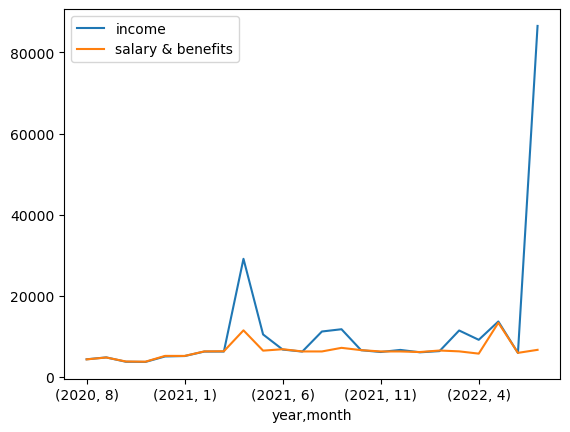

In [21]:
income = [s  for s in grouped.index.levels[-1] if ('Income'  in s and 'Reimbursement' not in s)]
sum([grouped[:,:, s ].fillna(0) for s in income]).plot(label = 'income')
grouped[:,:, 'Income - Salary & Benefits'].plot(label = 'salary & benefits')
plt.legend()

### plot expenses

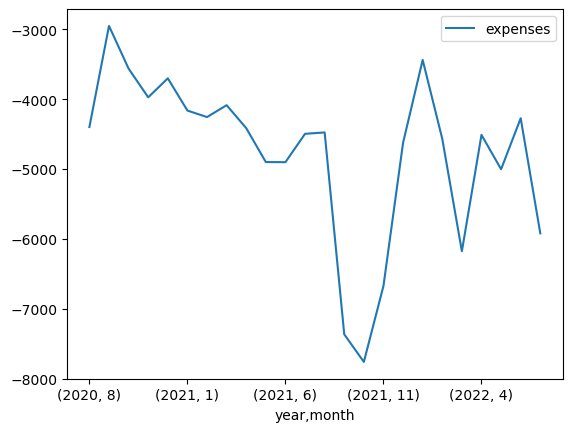

In [22]:
# sum up everything that is not Income or Investment
# expenses = [s  for s in grouped.index.levels[1] if not ('Income'  in s or 'Investments'  in s)]
expenses = set(grouped.index.levels[-1]).difference(['Investments']+ [s for s in grouped.index.levels[-1] if 'Income' in s])
sum([grouped[:,:, s ].fillna(0) for s in expenses]).plot(label = 'expenses')
plt.legend()

In [23]:
# bc.save_data()

### plot the savings

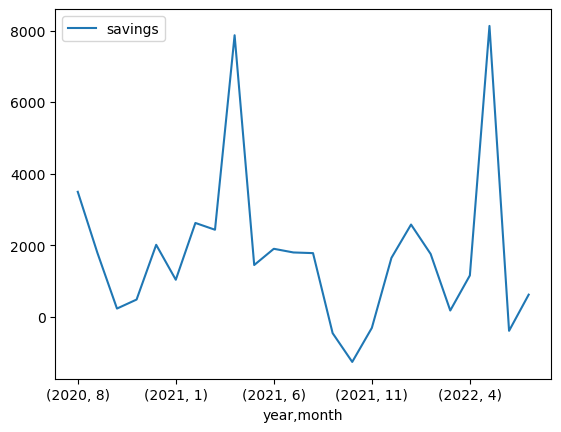

In [24]:
savings = set(grouped.index.levels[-1]).difference(['Investments', 'Income - Presents'])
# sum up everything that is not Investment or Presents to get the amount that can be saved each month
sum([grouped[:,:, s ].fillna(0) for s in savings]).plot(label = 'savings')
# (-grouped[:, 'Investments']).plot(label = 'Investments')
plt.legend()


# savings = set(grouped.index.levels[1]).difference(['Investments'])
# # sum up everything that is not Investment or Presents to get the amount that can be saved each month
# sum([grouped[:, s ].fillna(0) for s in savings]).plot(label = 'savings incl. presents')
# # (-grouped[:, 'Investments']).plot(label = 'Investments')
# plt.legend()

### using plotly

In [ ]:
plotly

In [25]:
import plotly.express as px

wide_df = px.data.medals_wide()

fig = px.bar(wide_df, x="nation", y=["gold", "silver", "bronze"], title="Wide-Form Input")
fig.show()

ModuleNotFoundError: No module named 'plotly'

## looking at the details

In [23]:
print('monthly mean expenses:')
grouped_month_mean = grouped.groupby(level=[0,-1]).mean()
grouped_month_mean

monthly mean expenses:


year  class                             
2020  Bill - Communications                  -55.838000
      Bill - Health                         -255.873333
      Bill - Insurrance                       -9.995000
      Bill - Utilities, Rent & Fees        -2304.510000
      Car                                   -191.140000
                                               ...     
2022  Out-of-pocket expense                  -70.423333
      Personal Care & Sport                 -146.942000
      Public Transport                      -119.032857
      Restaurants & Bars                    -307.925000
      Supermarket & Everyday commodities    -666.985714
Name: amount, Length: 66, dtype: float64

{'Income - Investments',
 'Income - Presents',
 'Income - Reimbursement',
 'Income - Salary & Benefits',
 'Investments',
 'Out-of-pocket expense'}

In [30]:
grouped[:,:,'Other'].sum()

-1660.51

In [31]:
grouped[:,:,'Out-of-pocket expense'].sum()

-660.13

In [44]:
(-grouped_month_mean[:,'Holidays - Transport'])

year
2020        NaN
2021    1102.57
2022     526.39
Name: amount, dtype: float64

In [45]:
(-grouped_month_mean[2020,'Holidays - Accomodation'])

nan

In [49]:
not all(df.isna())

False

In [54]:
grouped_month_mean[:,'Holidays - Transport']

year
2020        NaN
2021   -1102.57
2022    -526.39
Name: amount, dtype: float64

In [55]:
grouped_month_mean[:][classes]

KeyError: "['Holidays - Accomodation' 'Holidays - Transport'] not in index"

In [53]:
df = (-grouped_month_mean[:][classes])
df

InvalidIndexError: ['Holidays - Accomodation', 'Holidays - Transport']

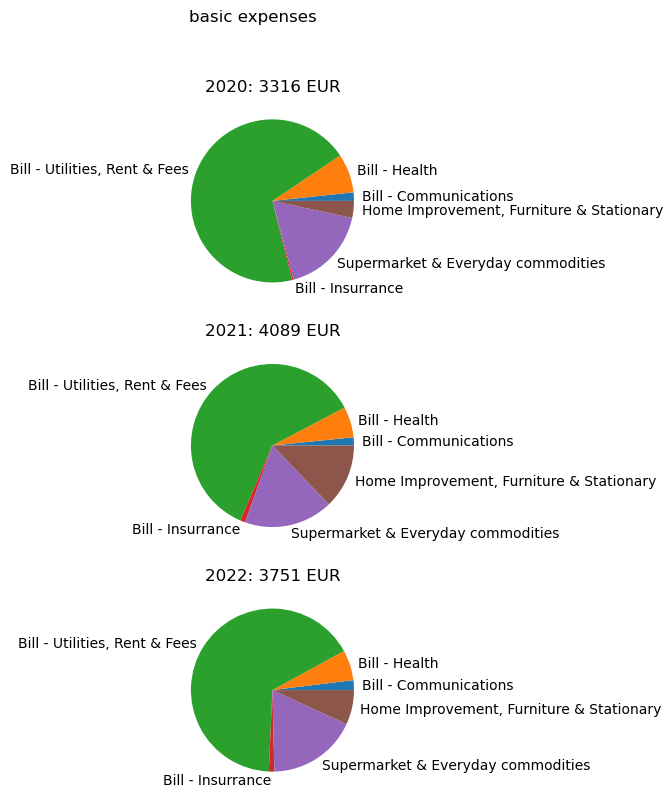

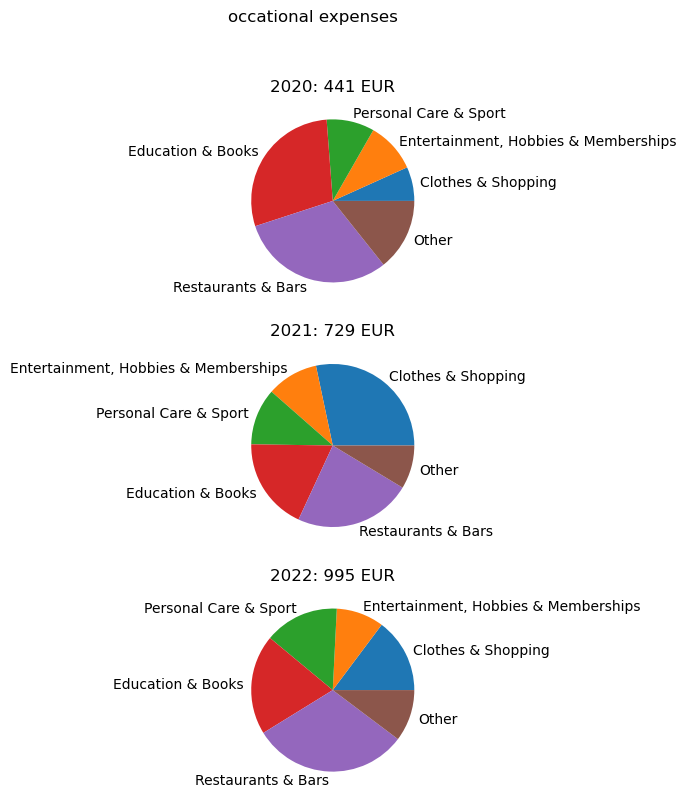

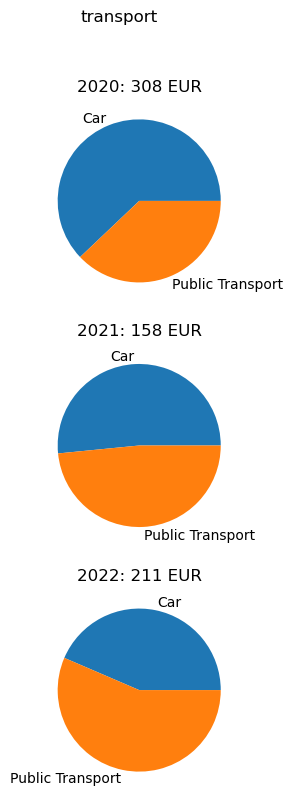

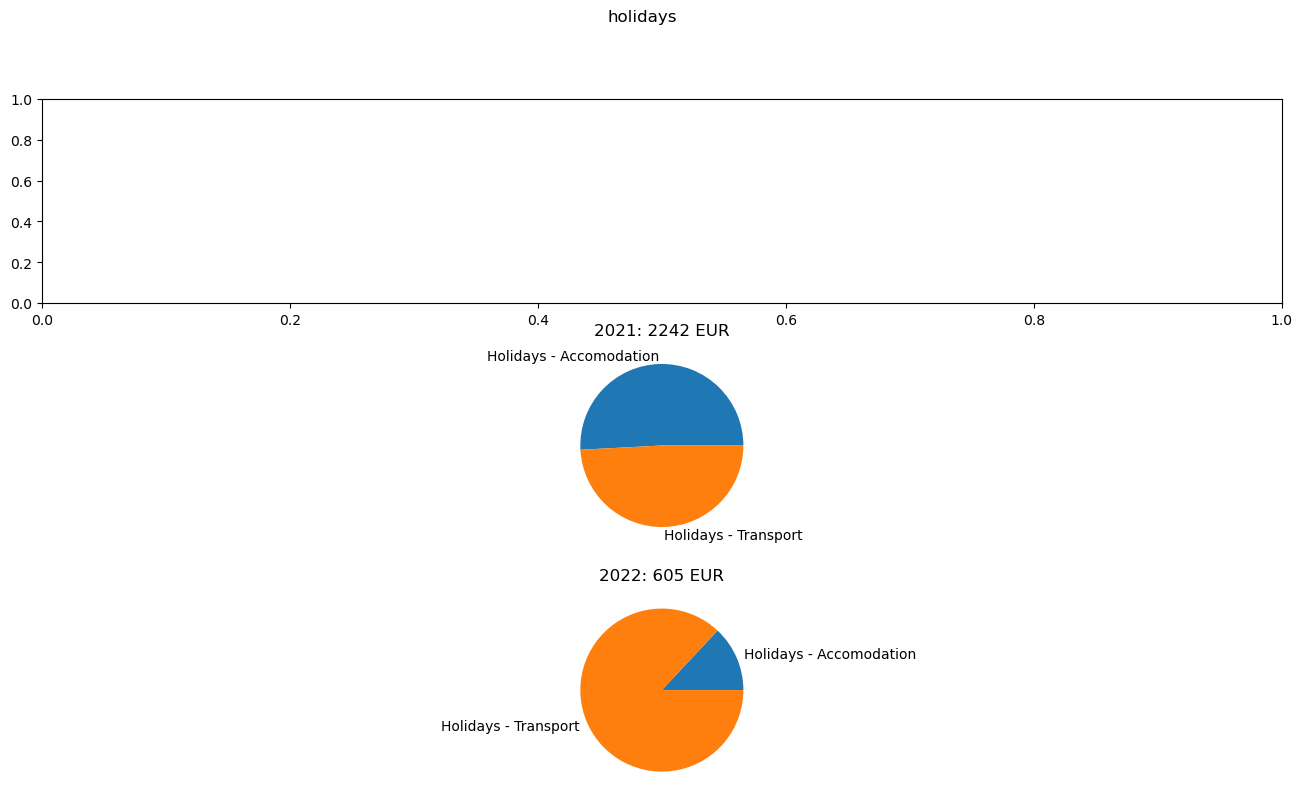

In [50]:
for group_name, classes in exepense_groups.items():
    fig, axes = plt.subplots(len(grouped_month_mean.index.levels[0]), 1, figsize = (16,9))

    for year, a in zip(grouped_month_mean.index.levels[0], axes):
        df = (-grouped_month_mean[year][classes])
        if not all(df.isna()):
            df.plot.pie(ylabel = '', title = f'{year}: {df.sum():0.0f} EUR', ax=a)
    plt.suptitle(group_name)

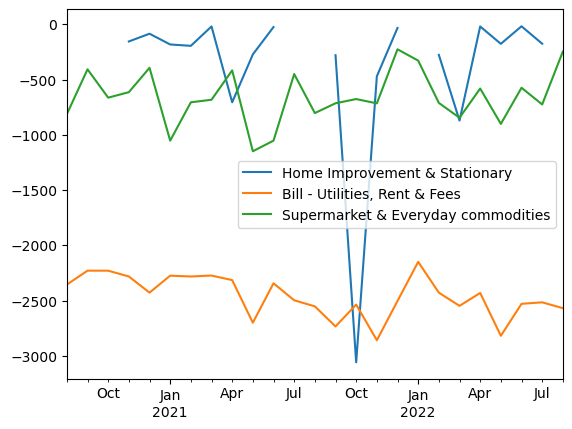

In [131]:
for label in set1:
    grouped[:, label].plot(label = label)
plt.legend()

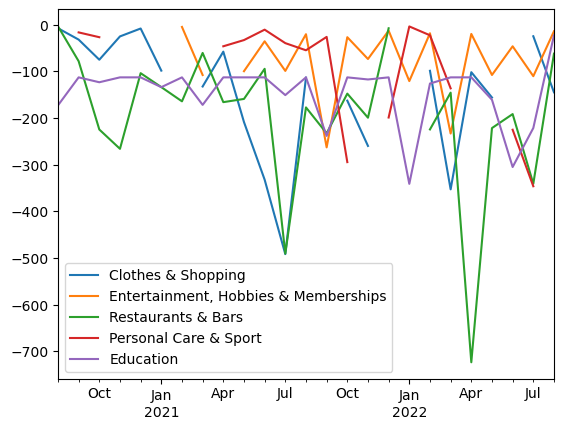

In [132]:
for label in set2:
    grouped[:, label].plot(label = label)
plt.legend()

<AxesSubplot: >

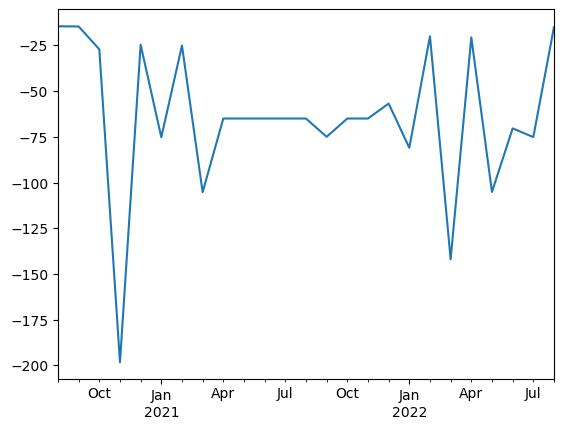

In [81]:
grouped[:,].plot()

<AxesSubplot: >

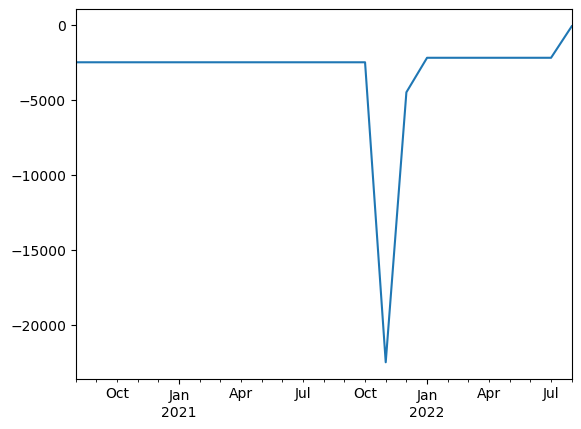

In [82]:
grouped[:,'Investments'].plot()

In [83]:
grouped[:,'Investments'].sum()

-80000.0